# The Variational Quantum Linear Solver

#### Editor's note:

Consulted Pennylane tutorial on VQLS, found [here](https://pennylane.ai/qml/demos/tutorial_vqls).

Qiskit version: `2.0.0`

In [3]:
%pip install --upgrade -r requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


### Importing libraries

In [54]:
from IPython.display import display

import qiskit as qk
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.circuit.library import UGate
from qiskit.exceptions import QiskitError
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2, EstimatorOptions
from qiskit.quantum_info import Statevector, Operator, PauliList, Operator, SparsePauliOp, Pauli
from qiskit.transpiler.passes import RemoveBarriers
from qiskit.visualization import array_to_latex, plot_histogram

import math
import random
import numpy as np
from numpy import pi
from numpy import array, sqrt

from scipy.optimize import minimize
import matplotlib.pyplot as plt

import tqdm

# For high-performance simulation
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as AerEstimatorV2

print(f"Qiskit version: {qk.__version__}")

Qiskit version: 2.0.0


## 1. Introduction

The Variational Quantum Linear Solver (VQLS) is a kind of variational quantum algorithm (VQA) that solves systems of linear equations. 

Given a matrix $A$, such that $A |x\rangle \ = \ |b\rangle$, where $|b\rangle$ is some known vector, the VQLS algorithm finds a normalized $|x\rangle$ that is proportional to $|x\rangle$, which makes the above equation true.



## 2. The Algorithm

We start off with a qubit register, with each qubit initialized to $|0\rangle$. 

First, we prepare a candidate solution, $|x(\alpha)\rangle$ conditioned on a set of parameters $\alpha$. This is done using an ansatz $V(\alpha)$, where $|x(\alpha)\rangle = V(\alpha) |0\rangle$. Next, prepare $|b\rangle = U|0\rangle$ for some unitary $U$.

Second, we design a quantum circuit to compute a cost, $C(\alpha)$, that captures the idea of the difference between $| x(\alpha) \rangle$ and the real solution, $|x_0\rangle$, to $A {|x\rangle} = {|b\rangle}$.

If the cost is greater than some parameter $\gamma$, the algorithm is run again with updated parameters, and if not, the algorithm terminates.

Next, using classical methods, we find a new parameter, $\alpha$, that reduces $C(\alpha)$.

We repeat this process until $C(\alpha)$ falls within a reasonable limit, at which point we settle with $|x(\alpha)\rangle$ as the final solution.

![alt text](images/bro.png)

### Cost Function

Several cost functions are proposed:

1. $C_G$

$$C_G = 1 - | \langle b| \frac{|\psi\rangle}{\|\psi\|} \rangle |^2$$

$$C_G = 1 - \frac{ \langle x | A^\dagger U | 0 \rangle \langle 0 | U^\dagger A | x \rangle }{\langle x | A^\dagger A | x \rangle}$$

We project $|\psi\rangle = A |x(\alpha)\rangle$ onto the subspace orthogonal to $|b\rangle$.
$C_G(\alpha)$ equals the norm squared of the projection.

Note that $|\psi\rangle$ is not normalized, so we need to normalize it before computing the projection.

As the number of qubits increases, the gradient of $C_G$ vanishes so we introduce the local cost function.

<br>

2. $C_L$, a local version of $C_G$.

First, let us define

$$P_1 = \left( \mathbb{1} - \frac{1}{n} \sum_{j=1}^{n} |0_j \rangle \langle 0_{j} | \otimes \mathbb{1}_{\bar{j}} \right)$$

where $\mathbb{1}_{\bar{j}}$ is the identity on all qubits except the j-th qubit.

Also,

$$P_0 = \frac{1}{2} + \frac{1}{2n} \sum_{j=1}^{n} Z_j$$

where $Z_j$ is the Pauli-Z operator on the j-th qubit and identity on every other qubit.

When multipled by a standard-basis vector, $P_0$ counts the number of 0's in the vector, and $P_1$ counts the number of 1's. For example, if $|a \rangle$ is a standard basis vector having $m$ 1's and $n$ qubits, then $P_1 |a\rangle = \frac{m}{n} |a\rangle$, and $P_0 |a\rangle = \frac{n-m}{n} |a\rangle$.

Notice that

$$P_1 = \mathbb{1} - P_0 $$

Therefore,

$$C_L = \frac{\hat{C}_L} {\| \psi\|^2} = \frac{\langle x | H_L | x \rangle} {\| \psi\|^2}$$

$$ = \frac{\langle x | A^\dagger U P_1 U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

$$ = \frac{\langle x | A^\dagger U P_1 U^\dagger A | x \rangle} {\langle x | A^\dagger U \mathbb{1} U^\dagger A | x \rangle}$$

$$ = \frac{\langle x | A^\dagger U \mathbb{1} U^\dagger A | x \rangle - \langle x | A^\dagger U P_0 U^\dagger A | x \rangle} {\langle x | A^\dagger U \mathbb{1} U^\dagger A | x \rangle}$$

$$ = 1 - \frac{\langle x | A^\dagger U P_0 U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

We can see the $C_G$ and $C_L$ differes by the middle term: $|0\rangle \langle 0|$ in $C_G$ compared to $P_0$ in $C_L$.

$$ = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n}\langle x | A^\dagger U Z_j U^\dagger A | x \rangle} {\langle x | A^\dagger A | x \rangle}$$

$$ = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n}\langle 0|V^\dagger A^\dagger U Z_j U^\dagger A V|0 \rangle} {\langle 0|V^\dagger A^\dagger A  V|0 \rangle}$$


Since controlled-Z gate is native to IBM Heron processor, we can directly implement Controlled-$Z_j$ gates to improve efficiency of the algorithm for IBM Heron processors.

Since

$$A = \sum_{l=1}^{L} c_lA_l$$
where $c_l \in \mathbb{C}$, we can expand $A$ to obtain

$$ C_L = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n} \sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^*\langle 0|V^\dagger A_{l'}^\dagger U Z_j U^\dagger A_l V|0 \rangle} {\sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^* \langle 0|V^\dagger A_{l'}^\dagger A_l  V|0 \rangle}$$


## 3. Building Quantum Circuit with Qiskit



### Consider an Example

Let us construct a 4x4 tridiagonal matrix, $A$. We generate a random vector $|x_0\rangle$ and obtain $|b\rangle$ from the equation $A |x_0\rangle =|b\rangle$. 

We apply VQLS, using $A$ and $|b\rangle$ as inputs, to solve for $|x\rangle$ in $A |x\rangle =|b\rangle$. We then compare our solution with the real solution $|x_0\rangle$.

In [55]:
A = np.array([[2,-1,0,0],
            [-1,2,-1,0],
            [0,-1,2,-1],
            [0,0,-1,2]])

print("Define the matrix, A, to be the following:")
display(array_to_latex(A))

Define the matrix, A, to be the following:


<IPython.core.display.Latex object>

### Decomposing A into LCU

We decompose $A$ into a Linear Combination of Pauli Strings (LCU). This is done by writing $A$ as a sum of Pauli operators, each multiplied by a coefficient.

In [56]:
# Apply SparsePauliOp()
LCU = SparsePauliOp.from_operator(A)
print(LCU, end="\n\n")

print("The Pauli strings are:")
print(LCU.paulis, end="\n\n")

print("The coefficients are:")
print(LCU.coeffs)

print(f"\nThe number of qubits is {LCU.num_qubits}.")

SparsePauliOp(['II', 'IX', 'XX', 'YY'],
              coeffs=[ 2. +0.j, -1. +0.j, -0.5+0.j, -0.5+0.j])

The Pauli strings are:
['II', 'IX', 'XX', 'YY']

The coefficients are:
[ 2. +0.j -1. +0.j -0.5+0.j -0.5+0.j]

The number of qubits is 2.


Hence, we have

$$
A = 2II - 1IX - 0.5XX - 0.5YY
$$

where $I$, $X$, $Y$ are Pauli matrices. 

### Defining Controlled-A Circuits
For the Hadamard Test, let us define the function `CA()` that creates controlled circuits for each Pauli string in the LCU. 

IX


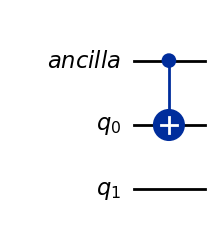

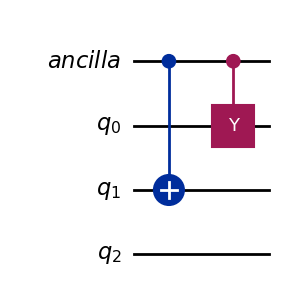

In [57]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Pauli, PauliList
from qiskit.exceptions import QiskitError

def CA(pauli_input, l=None):
    """
    Creates a controlled-Pauli circuit using an ancilla qubit as the control.
    
    Parameters:
        pauli_input (str, Pauli, PauliList or SparsePauliOp): 
            - A Pauli string (e.g., "IXY").
            - A Qiskit Pauli object (e.g., from SparsePauliOp.paulis[0]).
            - A Qiskit PauliList object, where the l-th Pauli will be used.
            - A Qiskit SparsePauliOp object, where the l-th Pauli will be used.
    
    The circuit uses two registers:
        - An ancilla register of size 1 named "ancilla" (the control qubit).
        - A data register of size nqubits named "q" (the target qubits).
    
    For each position in the Pauli operator:
        - 'I': Do nothing.
        - 'X': Apply a controlled-X (CX) gate.
        - 'Z': Apply a controlled-Z (CZ) gate.
        - 'Y': Apply a controlled-Y (CY) gate.
    
    Returns:
        QuantumCircuit: The constructed controlled-Pauli circuit.
    """
    
    # Convert input to a Pauli object if it is a string
    if isinstance(pauli_input, str):
        try:
            pauli = Pauli(pauli_input)  # Convert string to Pauli object
        except QiskitError:
            raise ValueError(f"Invalid Pauli string '{pauli_input}'. Allowed characters: I, X, Y, Z.")
    
    # If input is already a Pauli object, use it directly
    elif isinstance(pauli_input, Pauli):
        pauli = pauli_input
    
    # If input is PauliList or SparsePauliOp, extract the l-th pauli string
    elif isinstance(pauli_input, PauliList):
        try:
            pauli = pauli_input[l]  # Extract l-th pauli string
        except QiskitError:
            raise ValueError("The index, l, must be supplied if pauli_input contains more than one pauli string.")
        except IndexError:
            raise ValueError("The index, l, is out of bounds for the given PauliList.")
    
    elif isinstance(pauli_input, SparsePauliOp):
        try:
            pauli = pauli_input.paulis[l]  # Extract l-th pauli string
        except QiskitError:
            raise ValueError("The index, l, must be supplied if pauli_input contains more than one pauli string.")
        except IndexError:
            raise ValueError("The index, l, is out of bounds for the given PauliList.")
    
    # Reject invalid types
    else:
        raise TypeError(f"Expected input type str, Pauli, PauliList, or SparsePauliOp, but received {type(pauli_input)}.")
    
    # Determine the number of qubits
    nqubits = pauli.num_qubits
    
    # Create registers
    ancilla = QuantumRegister(1, name="ancilla")
    data = QuantumRegister(nqubits, name="q")
    
    # Create circuit
    circ = QuantumCircuit(ancilla, data, name="CA")
    
    # Loop over each Pauli term directly from the Pauli object
    for i, p in enumerate(pauli.to_label()):  # Ensure compatibility with string indexing. 
        # pauli.to_lable() converts Pauli Object to a string, e.g. "IXY"
        
        # Qiskit follows little Endian convention for qubit ordering. 
        # The most signifcant qubit is the one on the left in hand-written form. 
        # Hence, we need to reverse the index to match qubit numbering.
        i = nqubits - i - 1
        # E.g. nqubits =3, [0,1,2] becomes [2,1,0]
        
        if p == "I":
            continue
        elif p == "X":
            circ.cx(ancilla[0], data[i])
        elif p == "Z":
            circ.cz(ancilla[0], data[i])
        elif p == "Y":
            circ.cy(ancilla[0], data[i])
        else:
            raise ValueError(f"Unsupported Pauli operator: {p}")
    
    return circ
print(LCU.paulis[1])
display(CA(LCU.paulis[1]).draw("mpl"))
display(CA("IXY").draw("mpl"))

### Implement $|b\rangle$ with $U |0\rangle$

For simplicity, let use a $|b\rangle$ that is easy to implement. Let
$$|b\rangle = \frac{1}{2} \begin{pmatrix} 1 \\ 1 \\ 1 \\ 1 \end{pmatrix}$$

$|b\rangle$ can be prepared by applying a Hadamard gate to each qubit.

Given $A$ and $b$, we can easily obtain the solution x for validating the result.

$$|x\rangle = \begin{pmatrix} 1 \\ 1.5 \\ 1.5 \\ 1 \end{pmatrix}$$

In [58]:
# Solution to Ax = b
x = np.array([1,1.5,1.5,1])
np.matmul(A,x)

# The normalized solution x_0
x_0 = x/np.linalg.norm(x)
print("Normalized x: ", x_0)
display(array_to_latex(x_0))

Normalized x:  [0.39223227 0.58834841 0.58834841 0.39223227]


<IPython.core.display.Latex object>

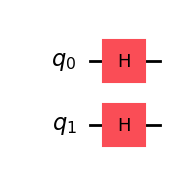

In [59]:
def U_hadamard(nqubits):
    """
    Creates a circuit of size 'nqubits' that represents U_hadamard.
    For our problem, we only need to apply Hadamard on each qubit to prepare |b>.
    
    In general, U_b would be a unitary that maps |0> to |b> (or vice versa).
    
    Returns:
        circuit (QuantumCircuit): A quantum circuit of size 'nqubits'.
    """
    circ = QuantumCircuit(nqubits, name="U_hadamard")
    # Example placeholder: apply H on each qubit
    for i in range(nqubits):
        circ.h(i)
    return circ

# |b> with two qubits:
display(U_hadamard(2).draw("mpl"))

### Fixed Structure Ansatz for $|x(\alpha)\rangle$
Consider the ansatz $V(\alpha)$, quantum a circuit that prepares a state $|x(\alpha)\rangle$ given a set of parameters, $\alpha$. 

There different techniques for preparing the ansatz, including fixed ansatz, variable ansatz and Quantum Alternating Operator Ansatz (QAOA). 

Here, we use a very basic fixed ansatz.

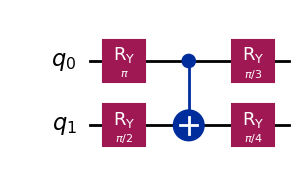

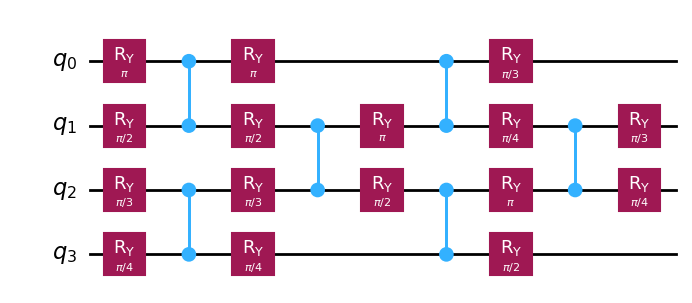

In [195]:

def apply_single_qubit_rotation(circuit, gate_type, angle, qubit_idx):
    gate_type = gate_type.strip().lower()
    if gate_type == "rx":
        circuit.rx(angle, qubit_idx)
    elif gate_type == "ry":
        circuit.ry(angle, qubit_idx)
    elif gate_type == "rz":
        circuit.rz(angle, qubit_idx)
    else:
        raise ValueError(f"Unsupported rotational gate: {gate_type}. Available gates are 'rx', 'ry', 'rz'.")

# Helper to apply two-qubit entangling gates
def apply_two_qubit_entangling(circuit, gate_type, ctrl, tgt):
    gate_type = gate_type.strip().lower()
    if gate_type == "cz":
        circuit.cz(ctrl, tgt)
    elif gate_type == "cx":
        circuit.cx(ctrl, tgt)
    elif gate_type == "cy":
        circuit.cy(ctrl, tgt)
    else:
        raise ValueError(f"Unsupported entangling gate: {gate_type}. Available gates are 'cz', 'cx', 'cy'.")

def fixed_ansatz(param, nqubits, rot_gates = "Ry", ent_gates = "CX"):
    """
    Creates a parameterized "ansatz circuit" on 'nqubits' data qubits.
    
    The circuit is built by first applying a layer of single-qubit rotation gates,
    followed by alternating layers of two-qubit entangling gates and additional
    single-qubit rotation layers. The entangling layers follow an alternating pattern:
    
    - Even-numbered layers (0, 2, ...): Apply entangling gates on qubit pairs (0,1), (2,3), ...
    - Odd-numbered layers (1, 3, ...):  Apply entangling gates on qubit pairs (1,2), (3,4), ...
    
    In non-final layers, the rotation gates are applied only to the qubits that will be entangled in the next layer.
    
    Input:
        param (list): A flat list of rotation angles. The list is partitioned into layers,
            with the first 'nqubits' elements used for the initial rotation layer.
        nqubits (int): The number of data qubits in the circuit.
        rot_gates (str, optional): The type of single-qubit rotation gate to apply 
            (e.g., "Rx", "Ry", or "Rz"). Default is "Ry".
        ent_gates (str, optional): The type of two-qubit entangling gate to apply 
            (e.g., "CX", "CZ", or "CY"). Default is "CX".
    
    Output:
    QuantumCircuit: The parameterized ansatz circuit.
    """
    
    # Initialize the ansatz circuit.
    ansatz = QuantumCircuit(nqubits, name="ansatz")
    
    layer_idx = 0
    
    # Populate the first layer of rotational gates
    for i in range(nqubits):
        try:
            apply_single_qubit_rotation(ansatz, rot_gates, param[i], i)
        except IndexError:
            raise IndexError("Index out of range for the first layer")
    param = param[nqubits:] # Remove the first layer from the parameters
    
    while True:
        # Even layer: entangle pairs (0,1), (2,3), ...
        if layer_idx % 2 == 0:
            if len(param) >= nqubits:
                for i in range(0, nqubits, 2):
                    apply_two_qubit_entangling(ansatz, ent_gates, i, i + 1)
                for i in range(0, nqubits):
                    apply_single_qubit_rotation(ansatz, rot_gates, param[i], i)
                param = param[nqubits:] # Remove this layer from the parameters
                layer_idx += 1
            else:
                return ansatz
        # Odd layer: entangle pairs (1,2), (3,4), ...
        elif layer_idx % 2 == 1:
            if len(param) >= max(nqubits - 2, 1):
                for i in range(1, nqubits - 1, 2):
                    apply_two_qubit_entangling(ansatz, ent_gates, i, i + 1)
                for param_idx, i in enumerate(range(1, nqubits - 1)):
                    apply_single_qubit_rotation(ansatz, rot_gates, param[param_idx], i)
                param = param[nqubits - 2:] # Remove this layer from the parameters
                layer_idx += 1
            else:
                return ansatz

param1 = [pi/1, pi/2, pi/3, pi/4]

param2 = [  pi/1, pi/2, pi/3, pi/4, 
            pi/1, pi/2, pi/3, pi/4, 
            pi/1, pi/2, 
            pi/3, pi/4, pi/1, pi/2, 
            pi/3, pi/4]

# Display the circuits with modified parameters
display(fixed_ansatz(param1, nqubits=2).draw("mpl"))
display(fixed_ansatz(param2, nqubits=4, ent_gates="cz").draw("mpl"))

In [ ]:
    # Deprecated fixed_ansatz() that takes a list of list as parameters (as opposed to a flat list).
    # 
    # for layer_idx, layer in enumerate(parameters):
    #     # For non-final layers, determine qubits that will be entangled in the next layer.
    #     if layer_idx < num_layers - 1:
    #         if layer_idx % 2 == 0:
    #             # Even layer: entangle pairs (0,1), (2,3), ...
    #             entangled = {i for pair in range(0, nqubits - 1, 2) for i in (pair, pair + 1)}        
    #         else:
    #             # Odd layer: entangle pairs (1,2), (3,4), ...
    #             entangled = {i for pair in range(1, nqubits - 1, 2) for i in (pair, pair + 1)}
    #         # Apply Ry only on qubits that will be involved in the next CZ layer.
    #         for i, theta in enumerate(layer[:nqubits]):
    #             if i in entangled:
    #                 apply_single_qubit_rotation(ansatz, rotational_gates, theta, i)
    #                 # ansatz.rx(theta, i)
    #     else:
    #         # For the final layer, apply Ry to all qubits.
    #         for i, theta in enumerate(layer[:nqubits]):
    #             apply_single_qubit_rotation(ansatz, rotational_gates, theta, i)
    #             # ansatz.rx(theta, i)
                
    #     # After each layer (except the final one) insert the alternating CZ entangling layer.
    #     if layer_idx < num_layers - 1:
    #         if layer_idx % 2 == 0:
    #             for i in range(0, nqubits - 1, 2):
    #                 apply_two_qubit_entangling(ansatz, entangling_gates, i, i + 1)
    #                 # ansatz.cz(i, i + 1)
    #         else:
    #             for i in range(1, nqubits - 1, 2):
    #                 apply_two_qubit_entangling(ansatz, entangling_gates, i, i + 1)
    #                 # ansatz.cz(i, i + 1)
                    
    # return ansatz

# params1 = [[pi/1, pi/2], [pi/1, pi/2]]

# params2 = [[pi/1, pi/2, pi/3, pi/4], 
#             [pi/1, pi/2, pi/3, pi/4], 
#             [pi/1, pi/2, pi/3, pi/4], 
#             [pi/1, pi/2, pi/3, pi/4]]

Only the parameters change for each run of the circuit. The $Rx$ gates search the state space, while the $CZ$ gates create "interference" between qubits. 


> Correction: Rz and CZ gates are native to IBM Heron processors. Rx is not. 

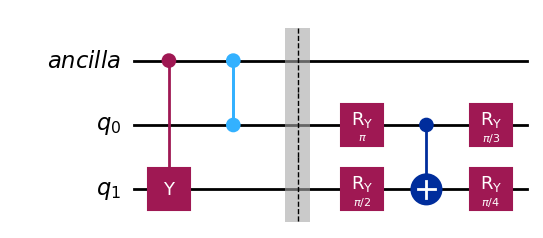

In [196]:
# Testing circuit composition

ancilla = QuantumRegister(1, name="ancilla")
data = QuantumRegister(2, name="q")
test_circ = QuantumCircuit(ancilla, data)

test_circ.compose(CA("YZ"), inplace=True)
test_circ.barrier()
test_circ.compose(fixed_ansatz(param=param1, nqubits=2), qubits=data[0:2], inplace=True)

display(test_circ.draw("mpl"))

### Hadamard Test for $C_L$

To calculate the local cost, we can use `Hadamard Test` circuit. The paper [5] introduces a new circuit, `Hadamard-Overlap Test`, to compute $C_L$. 

Recall the local cost, $C_L$:

$$ C_L = \frac{1}{2} - \frac{1}{2n} \frac{\sum_{j=1}^{n} \sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^*\langle 0|V^\dagger A_{l'}^\dagger U Z_j U^\dagger A_l V|0 \rangle} {\sum_{l=1}^{L} \sum_{l'=1}^{L} c_lc_{l'}^* \langle 0|V^\dagger A_{l'}^\dagger A_l  V|0 \rangle}$$

A basic `Hadamard Test` looks like this, where $|\psi \rangle$ is the state of the data qubits and $|0\rangle$ is the ancilla qubit. 

This Hadamard test is designed to calculate $\langle \psi|U|\psi \rangle$. Let the probability of measuring $|0\rangle$ be $p_0$ and the probability of measuring $|1\rangle$ be $p_1$. According the theory on the Hadamard Test, the real part would be $Re = p_0 - p_1$. The imaginary part can also be calculated using a slight different circuit. 

To get the real (and imaginary) part, measuring the ancilla qubit is not the most efficient method. 

A more efficient method is to use one of the qiskit primitives, `Estimator` or `EstimatorV2` (the other one is `Sampler`). 

Suppose the ancilla qubit is $|\psi\rangle$, then the expectation value is $\langle \psi | Z | \psi \rangle = p_0 - p_1 = Re$

Hence, in our case, we want to measure the expectation value of Pauli-Z on the ancilla qubit. 

![Hadamard test](images\Hadamard_test.webp)

Below is the circuit we want to build using Hadamard Test: 

Notice that for Pauli matrices, $A_l = A_{l}^\dagger$.

![Image from Pennylane](images\vqls_hadamard_test_circuit.png)

#### Constructing the Hadamard Test circuit

A_l is: IX
A_lp is: XX
j = 0

For the real part:


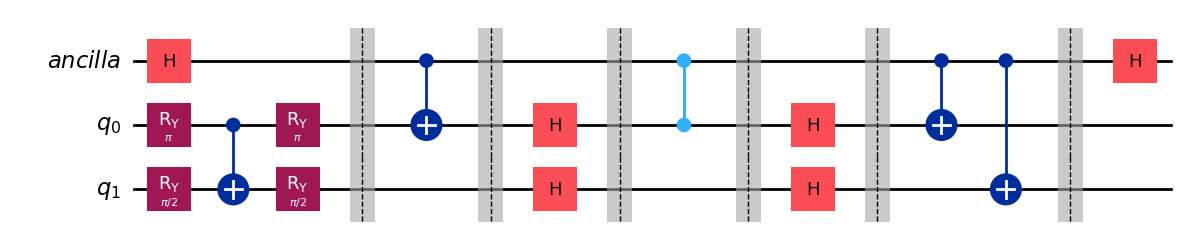

For the imaginary part:


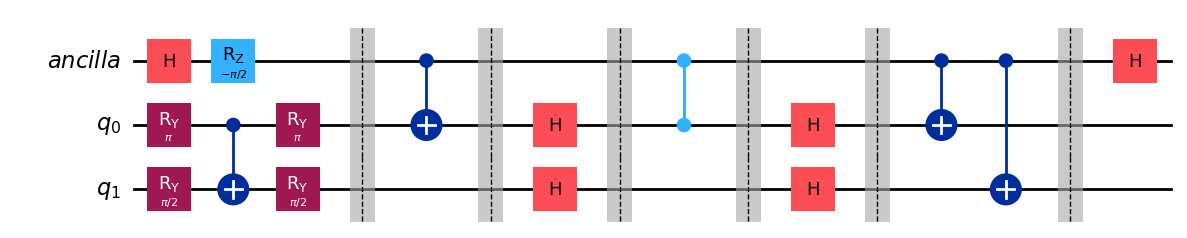

In [131]:

def local_hadamard_test(param, nqubits, l, j, lp, lcu = None, part="Re", rot_gates="Ry", ent_gates="CX"):
    """
    Builds the main circuit for the local Hadamard test as in your diagram.

    Args:
        param (list): Parameters for fixed_ansatz, e.g. [1, 2, 3, 3].
        nqubits (int): Number of data qubits (not counting the ancilla).
        l (int or Pauli_object): The l's pauli string in lcu (if lcu is provided), otherwise, Pauli_object for A_l (e.g. "IX").
        j (int): Index of the data qubit for the controlled-Z. If j = -1, skip the CZ.
        lp (int or Pauli_object): The l's pauli string in lcu (if lcu is provided), otherwise, Pauli_object for A_{l'} (e.g. "XX").
        nqubits (int): Number of data qubits (not counting the ancilla).

        part (str): "Re" or "Im". If "Im", apply a phase shift Rz(-pi/2) on the ancilla
                    to measure the imaginary part.
        lcu (PauliList or SparsePauliOp): PauliList or SparsePauliOp to use for l and lp. If lcu is None, then lp and l are 
        rot_gates (str): rotational gates for building the ansatz, "Ry" or "Rx" or "Rz".
        ent_gates (str): entangling gates for building the ansatz, "CX" or "CZ" or "CY".

    Returns:
        QuantumCircuit: The complete Hadamard test circuit with measurement on the ancilla.
    """
    # 0) If n_layers is not specified, determine it from the parameters and nqubits.
    
    # 0.5) If lcu is specified, use it to determine l and lp.
    if lcu is not None and isinstance(l,int) and isinstance(lp, int):
        # Check if l and lp are integers
        if not isinstance(l, int) or not isinstance(lp, int):
            raise TypeError("Indices l and lp must be integers.")
        
        # Check if l and lp are within the valid range
        if not (0 <= l < len(lcu)) or not (0 <= lp < len(lcu)):
            raise IndexError("Indices l and lp are out of range.")
        
        # Check if lcu is an instance of PauliList
        if isinstance(lcu, PauliList):
            pauli_l = lcu[l]
            pauli_lp = lcu[lp]
        # Check if lcu is an instance of SparsePauliOp
        elif isinstance(lcu, SparsePauliOp):
            pauli_l = lcu.paulis[l]
            pauli_lp = lcu.paulis[lp]
        else:
            raise TypeError("lcu must be an instance of PauliList or SparsePauliOp.")
    else:
        pauli_l = l
        pauli_lp = lp
    
    # 1) Create registers: 1 ancilla + nqubits data + 1 classical bit for measurement
    ancilla = QuantumRegister(1, name="ancilla")
    data = QuantumRegister(nqubits, name="q")
    # cbit = ClassicalRegister(1, name="c") # We are not taking measurements. 
    
    main_circuit = QuantumCircuit(ancilla, data, name="LocalHadamardTest")

    # 2) Hadamard on ancilla
    main_circuit.h(ancilla[0])

    # 2.5) (Optional) Phase shift for measuring imaginary part
    if part.lower().strip() in ["im", "imag", "imaginary"]:
        main_circuit.rz(-np.pi / 2, ancilla)

    # 3) Apply the fixed ansatz V(w) to the data qubits
    ansatz_circ = fixed_ansatz(param, nqubits, rot_gates, ent_gates)
    # Map data qubits of ansatz onto the 'data' register in main_circuit
    main_circuit.compose(ansatz_circ, qubits=data, inplace=True)
    main_circuit.barrier()
    
    # 4) Controlled A_l
    ca_l = CA(pauli_l)  # This subcircuit has 1 ancilla + nqubits data
    # Map the ancilla -> ancilla, data -> data[:]
    main_circuit.compose(
        ca_l,
        # qubits=[ancilla] + list(data),
        inplace=True
    )
    main_circuit.barrier()
    
    # 5) U_hadamard^\dagger
    ub_circ = U_hadamard(nqubits)
    main_circuit.compose(
        ub_circ.inverse(),
        qubits=data,  # apply to the data qubits
        inplace=True
    )
    main_circuit.barrier()
    
    # 6) Controlled-Z(ancilla, j) if j != -1
    if j != -1:
        main_circuit.cz(ancilla, data[j])
    main_circuit.barrier()
    
    # 7) U_hadamard
    main_circuit.compose(
        ub_circ,
        qubits=data,
        inplace=True
    )
    main_circuit.barrier()
    
    # 8) Controlled A_{l'}^\dagger
    # First build the subcircuit for A_{l'}, then invert it
    ca_lp = CA(pauli_lp)
    ca_lp_inv = ca_lp.inverse()
    main_circuit.compose(
        ca_lp_inv,
        qubits=[ancilla[0]] + list(data),
        inplace=True
    )
    main_circuit.barrier()
    
    # 9) Hadamard on ancilla
    main_circuit.h(ancilla)

    return main_circuit


print(f"A_l is: {LCU.paulis[1]}")
print(f"A_lp is: {LCU.paulis[2]}")
print("j = 0", end="\n\n")

print("For the real part:")
test_circ = local_hadamard_test(param1, nqubits=2, l=1, j=0, lp=2, lcu=LCU, part="Re")
display(test_circ.draw("mpl"))

print("For the imaginary part:")
test_circ2 = local_hadamard_test(param1, nqubits=2, l=1, j=0, lp=2, lcu=LCU, part="Im")
display(test_circ2.draw("mpl"))

## Evaluating the Quantum Circuit

### Aer Simulation

Here is a tutorial on [improving estimation of expectation values with Operator Backpropagation](https://learning.quantum.ibm.com/tutorial/improving-estimation-of-expectation-values-with-operator-backpropagation) from qiskit. 

#### Choosing a backend
For the backend, I will use `ibm_fez`, which is a Heron r2 machine. I do not have access to the real one. I will use `FakeFez()` to obtain a snapshot of the real machine.

If accessible, we can also choose a real device for backend, such as `ibm_brisbane`, though we need to connect to IBM Runtime Service. For instructions, search online or check out [Qiskit_Sample_Run](https://github.com/Weidsn/Quantum_Computing_Collaboration/blob/main/Qiskit/Qiskit_Sample_Run.ipynb) on Github. 

We only need calibration data from the quantum device for Aer Simulation. There is no rumtime cost from choosing so.


In [164]:
from qiskit_ibm_runtime.fake_provider import FakeFez

# For fake backend
backend = FakeFez()

# For real backend (ibm_brisbane)
# backend = QiskitRuntimeService().backend("ibm_brisbane")

# In general, to construct a AerSimulator from a backend
# simulator = AerSimulator().from_backend(backend)

simulator = AerSimulator()

#### Defining the observables

To calculate expectation values, we need to define the observables as qiskit `Pauli` objects, using `SparsePauliOp`. 

We are calculating the expectation value of $I \otimes I \otimes I \otimes \cdots \otimes Z$ with respect to the output of the Hadamard test. Hence, we need Pauli-Z operator on the ancilla qubit, and Identity operator on the data qubits. 

By the little Endian notation, the ancilla qubit is the least significant (LSB) so it comes last. 

In [ ]:
nqubits = 2

# Use Pauli-Z on the ancilla qubit, I on other qubits.
observable = SparsePauliOp("I"* nqubits + "Z")

#### Optimizing the circuit

Using qiskit `transpiler` or `pass_manager` to optimize and transpile the circuit for the quantum backend. 

The backend we are using, ibm_fez, has 156 qubits and has limited connectivity between qubits. It also supports a limited number of quantum gates, e.g., Rz, X, CZ and sqrt(X) a.k.a. SX.


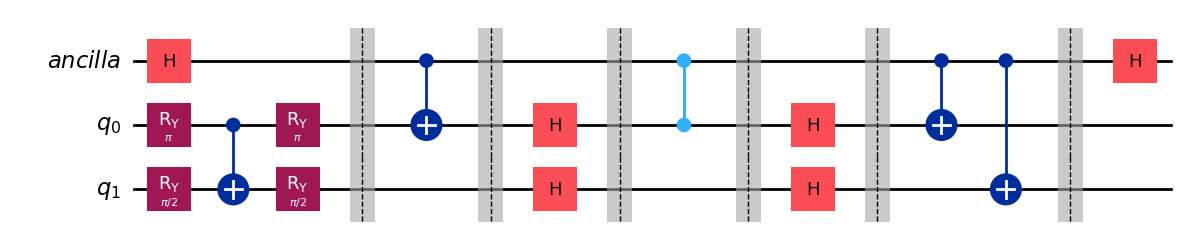

In [99]:
L = len(LCU.paulis)
n = nqubits
l = LCU.paulis[1]
lp = LCU.paulis[2] # from 1 to
j = 0 # from -1 to nqubits

qc = local_hadamard_test(param1, nqubits=2, l=l, j=j, lp=lp, part="Re")

qc_transpiled = transpile(circuits=qc, backend=simulator, optimization_level=1, layout_method="dense")
display(qc_transpiled.draw("mpl", idle_wires=False))

#### Removing barriers

We want to remove the barriers (gray dashed lines) from the circuit, which prevents full circuit optimization during transpilation, using `RemoveBarriers`. 

Here is a demostration. 

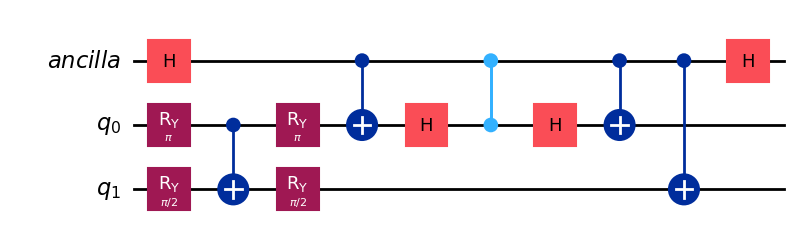

In [ ]:
qc_nb = RemoveBarriers()(qc)
qc_transpiled_nb = transpile(qc_nb, backend=simulator, layout_method="dense", optimization_level=1)
display(qc_transpiled_nb.draw("mpl", idle_wires=False))

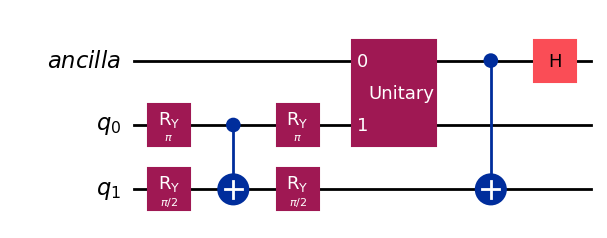

In [ ]:
qc_nb = RemoveBarriers()(qc)
qc_transpiled_nb = transpile(qc_nb, backend=simulator, layout_method="dense", optimization_level=3)
display(qc_transpiled_nb.draw("mpl", idle_wires=False))

#### Transpiling the observables

We need to apply the layout of the transpiled circuit to the observables as well. The observables should be mapped to the corresponding physical qubits.

In [ ]:
transpiled_obs = observable.apply_layout(qc_transpiled_nb.layout)

#### Building the Estimator

We import properties of the selected backend for Aer Simulation.

In [ ]:
from qiskit_aer.primitives import EstimatorV2 as AerEstimatorV2

# We import properties of the selected backend for Aer Simulation. 
estimator = AerEstimatorV2().from_backend(simulator)
estimator.options.resilience_level = 2


In [ ]:
job = estimator.run([(qc_transpiled_nb, transpiled_obs)])
result = job.result()

In [ ]:
print(result)

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(), dtype=float64>), stds=np.ndarray(<shape=(), dtype=float64>)), metadata={'target_precision': 0.0, 'circuit_metadata': {}, 'simulator_metadata': {'omp_enabled': True, 'parallel_experiments': 1, 'max_memory_mb': 40133, 'max_gpu_memory_mb': 0, 'time_taken_execute': 0.0003973, 'time_taken_parameter_binding': 2.12e-05}})], metadata={'version': 2})


#### Extracting the result

In [ ]:
exp_value_list = result[0].data.evs
print(exp_value_list)

5.0396666969134695e-33


### Putting everything together

The `eval_circ()` function transpiles and evaluates a circuit using Aer EstimatorV2. It returns the expectation value of Pauli-Z on the ancilla qubit.

In [110]:

def eval_circ(circ, backend, opt_lv=3, res_lv=2):
    """This circuit evaluates circ using Aer EstimatorV2 with observable Z for LSB and I for every other qubit.
    It is intended to be used on Hadamard test circuits, where LSB is the ancilla.
    In that case, it evaluates the expecation value of Pauli-Z for the ancilla.  
    
    Estimator Options:
    resilience level = res_lv
    
    Transpiler Options:
    optimization_level = opt_lv
    layout_method = "dense"
    
    Args:
        circ (QuantumCircuit): The Hadamard test circuit.
        backend (Backend): Backend to run the circuit on.
        opt_lv (int, optional): Transpiler optimization level (1 to 3). Defaults to 3.
        res_lv (int, optional): Estimator resilience level (0 to 2), which controls error mitigation. Defaults to 2.
        
    Returns:
        float: Expectation value of Pauli-Z on the ancilla (LSB).
    """
    
    nqubits = circ.num_qubits - 1
    # Remove barriers
    circ = RemoveBarriers()(circ)
    
    # Construct the observables
    obs = SparsePauliOp("I"* nqubits + "Z")
    
    # Transpile the circuit and observables
    circ_transpiled = transpile(circ, backend=backend, layout_method="dense", optimization_level=opt_lv)
    transpiled_obs = obs.apply_layout(circ_transpiled.layout)
    
    # Define the estimator
    estimator = AerEstimatorV2().from_backend(backend)
    estimator.options.resilience_level = res_lv
    
    result = estimator.run([(circ_transpiled, transpiled_obs)]).result()
    exp_value = result[0].data.evs
    return exp_value.item()
    

In [107]:
qc = local_hadamard_test(param1, nqubits=2, l=1, j=0, lp=2, lcu = LCU, part="re")
qc_im = local_hadamard_test(param1, nqubits=2, l=1, j=0, lp=2, lcu = LCU, part="im")

# Ideal backend
result_eval_circ_ideal = eval_circ(qc, backend=simulator)
print(type(result_eval_circ_ideal))
print(result_eval_circ_ideal)

<class 'float'>
5.0396666969134695e-33


In [ ]:
# FakeFez backend
result_eval_circ = eval_circ(qc, backend=FakeFez(), opt_lv=3, res_lv=2)
print(result_eval_circ)

<class 'float'>
0.00018064683265948912


In [116]:
# FakeFex backend 2nd try
result_eval_circ2 = eval_circ(qc_im, backend=FakeFez(), opt_lv=3, res_lv=2)
print(result_eval_circ2)

0.0001804755567959616


The `local_cost()` function combines every quantum step. It evaluates the local cost, given a set of parameters, $\alpha$.

In [159]:
def local_cost(param, nqubits, lcu, backend, Im_part=False, opt_lv=3, res_lv=2): 
    """This function evaluates the Hadamard test for a given parameter and LCU.

    Args:
        param: float
            The parameter for the Hadamard test
        lcu: PauliList or SparsePauliOp object
            The Pauli decomposition of the matrix A. 

    Returns:
        exp_value_list: list
    """
    L = len(lcu.paulis)
    nqubits = lcu.num_qubits
    
    # Evaluate the denominator
    Denominator = 0
    # For the real part
    for l in range(L):
        for lp in range(L):
            circ = local_hadamard_test(param, nqubits, l, -1, lp, part = "Re", lcu=lcu)
            # Multiplying coefficients with the expectation value.
            Denominator += (lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * 
                            eval_circ(circ, backend=backend, opt_lv=opt_lv, res_lv=res_lv))
    # Imaginary part
    if Im_part:
        for l in range(L):
            for lp in range(L):
                circ = local_hadamard_test(param, nqubits, l, -1, lp, part = "Im", lcu=lcu)
                # Multiplying coefficients with the expectation value.
                Denominator += (lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * 
                                   eval_circ(circ, backend=backend, opt_lv=opt_lv, res_lv=res_lv)) * 1.0j
    
    # Evaluate the Numerator
    Numerator = 0
    for l in range(L):
        for lp in range(L):
            for j in range(nqubits): # j is from 0 to nqubits-1
                circ = local_hadamard_test(param, nqubits, l, j, lp, part = "Re", lcu=lcu)
                # Multiplying coefficients with the expectation value.
                Numerator += (lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * 
                                eval_circ(circ, backend, opt_lv, res_lv))
    # Imaginary part
    if Im_part:
        for l in range(L):
            for lp in range(L):
                for j in range(nqubits):
                    circ = local_hadamard_test(param, nqubits, l, j, lp, part = "Im", lcu=lcu)
                    # Multiplying coefficients with the expectation value.
                    Numerator += (lcu.coeffs[l] * np.conjugate(lcu.coeffs[lp]) * 
                                    eval_circ(circ, backend, opt_lv, res_lv)) * 1.0j
    
    # The final result
    local_cost = 1/2 + ( 1/(2*nqubits) * (Numerator / Denominator))
    return abs(local_cost)

#### Testing 

Testing the function, `local_cost` with respect to parameters [[pi/1, pi/2], [pi/1, pi/2]].

In [ ]:
param3 = [pi/3, pi/5, pi/3, pi/5]

# Testing with only real part. Using ideal simulator. Without abs()
result_local_cost = local_cost(param3, nqubits = 2, lcu = LCU, backend=simulator, Im_part=True)
print("Ideal simulation result:")
print(result_local_cost)

Ideal simulation result:
<class 'numpy.float64'>
0.2020254258048106


In [130]:
# Testing with combined imaginary part. Without abs(), backend = FakeFez
result_local_cost2 = local_cost(param3, nqubits=2, lcu=LCU, backend=FakeFez(), Im_part=True)
print(result_local_cost2)

<class 'numpy.float64'>
0.2115077664613891


In [ ]:
# No imaginary part. Without abs(), backend = FakeFez
result_local_cost3 = local_cost(param3, nqubits=2, lcu=LCU, backend=FakeFez(), Im_part=False)
print(result_local_cost3)

<class 'numpy.float64'>
0.21224397433503872


### Iterating over parameters

Since scipy's `minimize` function takes flat (1D) numpy arrays as inputs, we need to modify our `local_cost()` function by defining a `local_cost_flat()`.

Defining a CostTracker object to track costs. 

In [158]:
from scipy.optimize import minimize

# No need to reshape parameters. 
# def local_cost_flat(parameters, lcu, backend, num_layers=2, nqubits=2, Im_part=False, opt_lv=3, res_lv=2):
#     parameters = np.reshape(parameters, (num_layers, nqubits))
#     return local_cost(parameters, lcu, backend, Im_part=Im_part, opt_lv=opt_lv, res_lv=res_lv)


class CostTracker:
    # Initialize CostTracker object with cost function and arguments
    def __init__(self, cost_fn, *args, **kwargs):
        self.cost_fn = cost_fn
        self.args = args
        self.kwargs = kwargs
        self.history = []
        self.latest_cost = None

    # Making CostTracker callable with a single argument, 'param'. 
    # This allows us to use scipy.optimize.minimize
    def __call__(self, param):
        # Running the cost_fn on param, using args and kwargs stored when initializing the object. 
        cost = self.cost_fn(param, *self.args, **self.kwargs)
        self.history.append(cost)
        self.latest_cost = cost
        return cost

    def callback(self, xk):
        print(f"Step: params = {xk}, cost = {self.latest_cost}")

In [157]:
# Flattening params1
# params1 = [[pi/3, pi/5], [pi/3, pi/5]]
# params1_flat = np.ravel(params1)
# print(type(params1_flat))
# print(params1_flat)

tracked_cost = CostTracker(local_cost, 2, LCU, simulator)
# Perform 2 iterations using minimize
result = minimize(tracked_cost, x0=param3, method="COBYLA", options={'maxiter': 2}, callback=tracked_cost.callback)
print(result)
x_1 = result.x

Step: params = [2.04719755 0.62831853 1.04719755 0.62831853], cost = 0.2020254258048106
Step: params = [1.04719755 1.62831853 1.04719755 0.62831853], cost = 0.25749962331416265
Step: params = [1.04719755 0.62831853 1.04719755 0.62831853], cost = 0.25749962331416265
 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: 0.2020254258048106
       x: [ 1.047e+00  6.283e-01  1.047e+00  6.283e-01]
    nfev: 2
   maxcv: 0.0


Defining a callback function to print the progress of the optimization.

In [160]:
result2 = minimize(tracked_cost, x0=x_1, method="COBYLA", options={'maxiter': 100}, callback=tracked_cost.callback)
print(result2)
x_2 = result2.x

Step: params = [2.04719755 0.62831853 1.04719755 0.62831853], cost = 0.2020254258048106
Step: params = [1.04719755 1.62831853 1.04719755 0.62831853], cost = 0.25749962331416265
Step: params = [1.04719755 0.62831853 2.04719755 0.62831853], cost = 0.4470910654590855
Step: params = [1.04719755 0.62831853 1.04719755 1.62831853], cost = 0.4130524395537715
Step: params = [ 0.87898169 -0.11480043  0.40729481  0.528308  ], cost = 0.23500687942048054
Step: params = [0.77682764 0.17651738 0.01869498 0.46757366], cost = 0.17191887063671846
Step: params = [ 0.63719636 -0.11480043  0.47085466  0.528308  ], cost = 0.2755796732770063
Step: params = [ 1.217231   -0.42353634  0.59814682  0.46629953], cost = 0.2089664429020449
Step: params = [ 1.67065271 -0.60629686  0.56482528  0.36681575], cost = 0.10242981233268339
Step: params = [ 1.69689951 -0.98277721  0.88004741  0.2762141 ], cost = 0.07359292872486878
Step: params = [ 1.63181117 -0.5668298   0.54534959  0.12380468], cost = 0.07772692625155847
St

In [170]:
x_2 = result2.x

result3 = minimize (tracked_cost, x0=x_2,
                    method="COBYLA", 
                    options={'maxiter': 200, 'disp':True}, 
                    callback=tracked_cost.callback,)
print(result3)
x_3 = result3.x

Step: params = [ 2.95156122 -2.43451686  0.55310599 -0.38460037], cost = 0.01627090549802629
Step: params = [ 1.95156122 -1.43451686  0.55310599 -0.38460037], cost = 0.12305347347421325
Step: params = [ 1.95156122 -2.43451686  1.55310599 -0.38460037], cost = 0.08940022138888781
Step: params = [ 1.95156122 -2.43451686  0.55310599  0.61539963], cost = 0.08056340105672544
Step: params = [ 1.50346565 -2.74139207  0.28331305 -1.1797417 ], cost = 0.20575555614679863
Step: params = [ 1.72751343 -2.58795446  0.41820952 -0.78217103], cost = 0.21925217336190927
Step: params = [ 2.18871703 -2.46166991  0.52923407 -0.45495636], cost = 0.06414629224459567
Step: params = [ 1.95156122 -2.35198273  0.45922778 -0.38460037], cost = 0.02411599674595133
Step: params = [ 1.95246022 -2.26062454  0.71622545 -0.45978477], cost = 0.018693666395434128
Step: params = [ 1.95624062 -2.461914    0.58231953 -0.13787366], cost = 0.02525008501951176
Step: params = [ 1.88545383 -2.49402531  0.5255824  -0.46800306], cos

### Verifying the output

In [166]:
output_parameter = x_3

print(output_parameter)
# Plug x_3 into ansatz. 

# Defining a function that return the ideal statevector obtained from the ansatz with set parameters. 
def evaluate_ansatz(param, rot_gates="Ry", ent_gates = "CX"):
    circ = fixed_ansatz(param, nqubits=nqubits, rot_gates=rot_gates, ent_gates=ent_gates)
    circ.save_statevector() # To tell Aer simulator to save the statevector.
    
    simulator = AerSimulator()  # Set up the simulator
    
    circ = transpile(circ, simulator) # transpile the circuit
    
    result = simulator.run(circ).result() # Obtain the result
    
    statevector = result.get_statevector() # Get the statevector

    return statevector

[ 1.57429605 -3.13402658  0.44369031 -0.44381624]


In [168]:
statevector = evaluate_ansatz(output_parameter, rot_gates="Ry", ent_gates = "CX")

display(array_to_latex(statevector))

<IPython.core.display.Latex object>

In [191]:
print(np.matmul(A, np.array(statevector)), "\n")

print(f"Obtained result: \n{np.matmul(A, np.array(statevector).real)}")
ketb = np.array((1/np.sqrt(2)) * np.array([1, 1, 1, 1]))
print(f"Normalized target vector, b: \n{ketb}")

[ 0.71286554+0.j -0.70990565+0.j -0.71018991+0.j  0.7131243 +0.j] 

Obtained result: 
[ 0.71286554 -0.70990565 -0.71018991  0.7131243 ]
Normalized target vector, b: 
[0.70710678 0.70710678 0.70710678 0.70710678]


## 4. Acknowledgements

This implementation is based on the work presented in the research paper [5] by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles.